In [119]:
import re
import random
import pandas as pd
import hashlib

In [120]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [121]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Logging in Python,190.756453,38.151291,63.698985,5
Pandas,344.167443,38.240827,58.125241,9
CCH Axcess,527.040327,18.173804,36.124804,29
DAX,558.679644,62.075516,144.220346,9
Azure Private DNS,814.904758,90.544973,193.098524,9
Terraform,1081.829820,90.152485,268.656175,12
Azure AD Authentication,1215.337767,101.278147,161.399445,12
Azure Functions + PP365,1434.692707,89.668294,246.868659,16
Microsoft Purview,1532.259692,31.922077,48.822647,48
TSQL,1589.580108,66.232505,169.042963,24


# Histogram

sum of ages: ~52720.13


<Axes: >

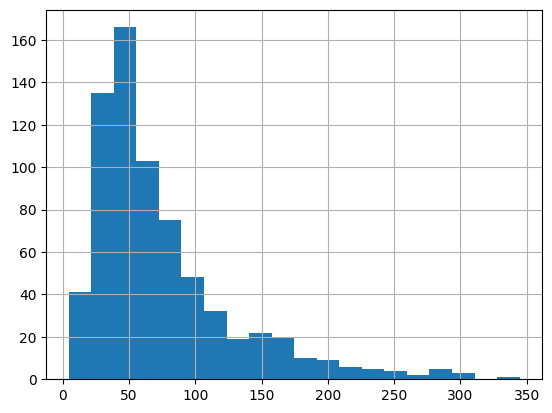

In [122]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~52720.13


<Axes: >

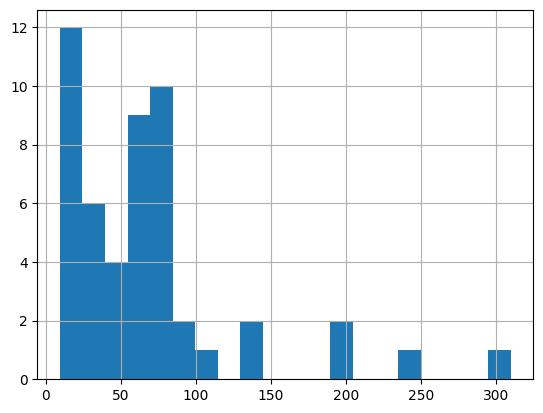

In [123]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [124]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [125]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [126]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [127]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [128]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [129]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [130]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [131]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [132]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [133]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [ ]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 706
Total card age: 52720.13


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,frequency,count,n_fold,neg_age
208,Logging in Python,Q: What is one advantage of using dictConfig o...,ec5e9d3bc2269de5497fc5319804de0e,63.698985,38.151291,63.698985,190.756453,0.052294,5,5,0,0,-63.698985
445,Logging in Python,Q: What is a NullHandler used for in Python's ...,46b8e5037ad9edd8e955e07028c2a2d1,39.985242,38.151291,63.698985,190.756453,0.052294,5,5,1,0,-39.985242
677,Logging in Python,Q: What is a common practice for naming logger...,561e72f35d816db72d07a7bd7c32e259,37.004632,38.151291,63.698985,190.756453,0.052294,5,5,2,0,-37.004632
209,Logging in Python,Q: What is the role of a Formatter in a loggin...,91ae0e13c8f5de1690ddaded2c58c40e,26.014679,38.151291,63.698985,190.756453,0.052294,5,5,3,0,-26.014679
446,Logging in Python,Q: Why is it important to centralize logging c...,3821980b540780d0b4e8795e86d7583f,24.052914,38.151291,63.698985,190.756453,0.052294,5,5,4,0,-24.052914
210,Pandas,What is the difference between pivot() and piv...,0326413872dbb2c2145a4738c869f97d,58.125241,38.240827,58.125241,344.167443,0.400055,9,9,0,0,-58.125241
447,Pandas,How do you use apply() with a lambda function ...,6f18e8724240630a3710e36eb67d1592,47.533853,38.240827,58.125241,344.167443,0.400055,9,9,1,0,-47.533853
678,Pandas,Resampling changes the frequency of your time-...,2ec24e24174ee6f9e83d57ca1b558807,40.418664,38.240827,58.125241,344.167443,0.400055,9,9,2,0,-40.418664
211,Pandas,How can you apply multiple aggregation functio...,97c849b0662c13306e30c1cf72bf4b71,39.394945,38.240827,58.125241,344.167443,0.400055,9,9,3,0,-39.394945
448,Pandas,How do you apply multiple aggregation function...,e3d108d06b1395c901d1e100b5c1dc31,37.682116,38.240827,58.125241,344.167443,0.400055,9,9,4,0,-37.682116



## Random

In [135]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [136]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,frequency,count,n_fold,neg_age
14,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,344.718179,94.512504,344.718179,2835.375123,0.709236,30,30,0,0,-344.718179
239,Azure Developer Associate,The top-level resource in Azure Container Inst...,3f04022b2316ce5e2c67d6b869e6aea9,309.880481,68.825630,309.880481,3441.281520,0.697381,50,50,0,0,-309.880481
24,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,308.410750,93.288538,308.410750,2891.944663,0.940149,31,31,0,0,-308.410750
35,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,297.096524,93.592035,297.096524,3556.497331,0.398583,38,38,0,0,-297.096524
48,Azure DevOps Pipelines,What is the default working directory for a pi...,4874a140413af48140b5cb984340bd62,292.477899,104.981429,292.477899,1679.702863,0.045156,16,16,0,0,-292.477899
290,Azure DevOps Pipelines,How can you pass secrets securely in Azure Dev...,5b00153ed3bdf8955aa08ad4e2779a5c,290.019113,104.981429,292.477899,1679.702863,0.045156,16,16,1,0,-290.019113
277,Asynchronous Python,async with (async context manager)\nManages as...,359a45c84a774bead164891fd0454b3c,287.092073,93.592035,297.096524,3556.497331,0.398583,38,38,1,0,-287.092073
54,Python,Q:\nWhich itertools function can be used to cr...,e10c94072687976e9627c8fc187d9ea3,284.918714,61.474666,284.918714,3258.157285,0.600353,53,53,0,0,-284.918714
72,PowerShell Modules,Find-Module\n\nDefinition: Searches for module...,4441d462ea754e1bb6a659efa359382f,280.870347,96.615825,280.870347,2608.627263,0.470405,27,27,0,0,-280.870347
81,Terraform,You can create and use Terraform modules that ...,dee44c7482afdda345bd10bdad89f932,268.656175,90.152485,268.656175,1081.829820,0.137101,12,12,0,0,-268.656175


In [137]:
existing_cards['age'].mean()

74.67440038565314